<a href="https://colab.research.google.com/github/pachterlab/monod/blob/anndata/test/simulation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* test

In the current notebook, we test *Monod* on simulations.

## Import prerequisites

### Install monod

In [2]:
!git clone -b anndata --single-branch https://github.com/pachterlab/monod.git

Cloning into 'monod'...
remote: Enumerating objects: 1141, done.
remote: Counting objects: 100% (570/570), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 1141 (delta 445), reused 435 (delta 366), pack-reused 571 (from 1)
Receiving objects: 100% (1141/1141), 25.13 MiB | 3.54 MiB/s, done.
Resolving deltas: 100% (656/656), done.


In [3]:
!git clone https://github.com/pachterlab/monod_examples.git

Cloning into 'monod_examples'...
remote: Enumerating objects: 1492, done.
remote: Counting objects: 100% (433/433), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 1492 (delta 192), reused 399 (delta 181), pack-reused 1059 (from 1)
Receiving objects: 100% (1492/1492), 1.07 GiB | 29.92 MiB/s, done.
Resolving deltas: 100% (536/536), done.
Updating files: 100% (92/92), done.


### Import packages

Let's make sure that the version is correct.

In [4]:
!pip install scanpy loompy numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 798.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.8 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52019 sha256=a7d936ad1630399fbf2f7632ef6f649abdd46141eee55de74bcf97d28b902c7e
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
  Created wheel for session-info:

In [5]:
import sys
sys.path.insert(0, 'monod/src/monod')

import extract_data, cme_toolbox, inference, analysis, mminference

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import anndata as ad
from IPython.display import display, Markdown
import scanpy as sc
import random

In [7]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

## Generate data

### Functions

In [8]:
class BurstModel():
    """
    Given parameters for bursty transcription, splicing, deg generate P(U,S) for set of (U,S) counts
    """
    def __init__(self,quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T

    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)

    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p

        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, log10p, limits):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        gf = self.eval_model_pgf(log10p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))

        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        Pss = Pss.squeeze()
        return Pss

    def sample(self, log10p, num_data_points):
        """
        Given parmaters, sample (U,S) counts
        N = U (nascent/unspliced)
        M = S (mature/spliced)
        """
        b, beta, gamma = 10 ** log10p
        max_mean = b*np.asarray([1/beta,1/gamma])
        max_std = np.sqrt(max_mean*(1+np.asarray([1+b, 1+b*beta/(beta+gamma)])))
        mx = np.maximum((max_mean + 10*max_std).astype(int),15)

        Pss = self.get_Pss(log10p,mx)

        p_flat = Pss.flatten()
        x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
        X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
        x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector

        samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
        d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]
        return d_N, d_M

In [9]:
def seq(Y, lam, gene_length=1):
    """
    Y: a list of two 2d arrays for nascent and mature counts
    """
    Y_N, Y_M = Y
    lam_N, lam_M = lam
    n, p = Y_N.shape
    if len(gene_length) == p:
        X_N = np.random.poisson(Y_N*lam_N*gene_length[None,:])
    else:
        X_N = np.random.poisson(Y_N*lam_N)
    X_M = np.random.poisson(Y_M*lam_M)
    return X_N, X_M

### Simulate

In [10]:
n_cells = 1000
n_genes = 1000
params = np.zeros((n_genes,3)) # log10 p
Y_N = np.zeros((n_cells,n_genes))
Y_M = np.zeros((n_cells,n_genes))

for g in range(n_genes):
    params[g,0] = 0.5+np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
    params[g,1] = np.random.normal(1,0.1)  #beta
    params[g,2] = np.random.normal(0,0.1) #gamma
    log10p = np.asarray(params[g])
    burst_model = BurstModel()
    Y_N[:,g], Y_M[:,g] = burst_model.sample(log10p, n_cells)

In [11]:
# Open the file
gene_names = []
gene_length = []
with open('/content/monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1', 'r') as f:
    # Iterate through each line in the file
    for line in f:
        # Split the line into parts (assuming space or tab separated values)
        gene_length.append(line.split()[1])
        gene_names.append(line.split()[0])

In [12]:
X_N, X_M = seq([Y_N,Y_M], lam=(10**(-5),0.1), gene_length=np.array(gene_length[:n_genes],dtype=int))

In [13]:
# Create an AnnData object with the spliced data as the main matrix (X)
adata = ad.AnnData(X=X_M)
adata.layers['unspliced'] = X_N
adata.layers['spliced'] = X_M
adata.var_names = gene_names[:n_genes]
adata.var

""
Gnai3
Cdc45
H19
Pbsn
Scml2
...
Pex5
Slc25a18
Cdt1
Mc5r


## Set up model and perform inference.

In [14]:
# Define model.
fitmodel = cme_toolbox.CMEModel('Bursty','Poisson')
transcriptome_filepath = './monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

# Perform inference. Below is the default.
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
samp_lb, samp_ub = [-8, -3],[-5, 0]
grid = [6,7]

adata = inference.perform_inference(adata, fitmodel, n_genes=n_genes, seed=5,
            phys_lb=lb, phys_ub=ub, gridsize=grid, samp_lb=samp_lb, samp_ub=samp_ub,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1},
            transcriptome_filepath=transcriptome_filepath, poisson_average_log_length=5,
            dataset_string='sim', viz=False, num_cores=2)

INFO:root:Directory sim created.
INFO:root:Beginning data extraction.
INFO:root:Dataset: sim


The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 


INFO:root:Added lengths
INFO:root:1000 cells detected.
INFO:root:Total of 274 genes selected.


274 genes retained after expression filter.
['unspliced', 'spliced'] previous ordering
['unspliced', 'spliced'] ordered for histogram


INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Directory sim/Bursty_Poisson_6x7 created.
INFO:root:Global inference parameters stored to sim/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting parallelized grid scan.


LayersView with keys: unspliced, spliced
['unspliced', 'spliced']


100%|██████████| 42/42 [07:42<00:00, 11.02s/it]
INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory sim/Bursty_Poisson_6x7/analysis_figures created.
INFO:root:Grid scan results stored to sim/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Runtime: 463.0 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved.


Layers with keys: unspliced, spliced
['unspliced', 'spliced']


INFO:root:AIC values calculated.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 55.1 seconds.
INFO:root:Uncertainties per gene calculated.


## Check parameters

In [15]:
adata.uns['search_result'].samp_optimum

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-5.0, -1.0)

In [16]:
# Optimum biological parameters.
display(adata.var[[i for i in adata.var.keys() if 'param' in i]])

,param_$\log_{10} b$,param_$\log_{10} \beta$,param_$\log_{10} \gamma$
Gnai3,0.424644,0.911928,-0.242587
Cdc45,0.547534,0.923616,0.078786
Scml2,0.408059,0.921709,-0.362866
Apoh,0.314468,1.026446,-0.138186
Wnt3,0.449470,1.022385,0.043403
...,...,...,...
Eif2ak4,0.482124,0.912920,-0.124972
Sod2,0.515411,0.967665,-0.124060
Col5a3,0.525074,0.918432,0.011837
Abca13,0.530161,1.026939,0.167257


In [17]:
# Check if each of the genes in idx is in adata.var_names
idx = [gene in adata.var_names for gene in gene_names[:n_genes]]
param = params[idx]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0.98, 'Scatter plot of true aram vs inferred param')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


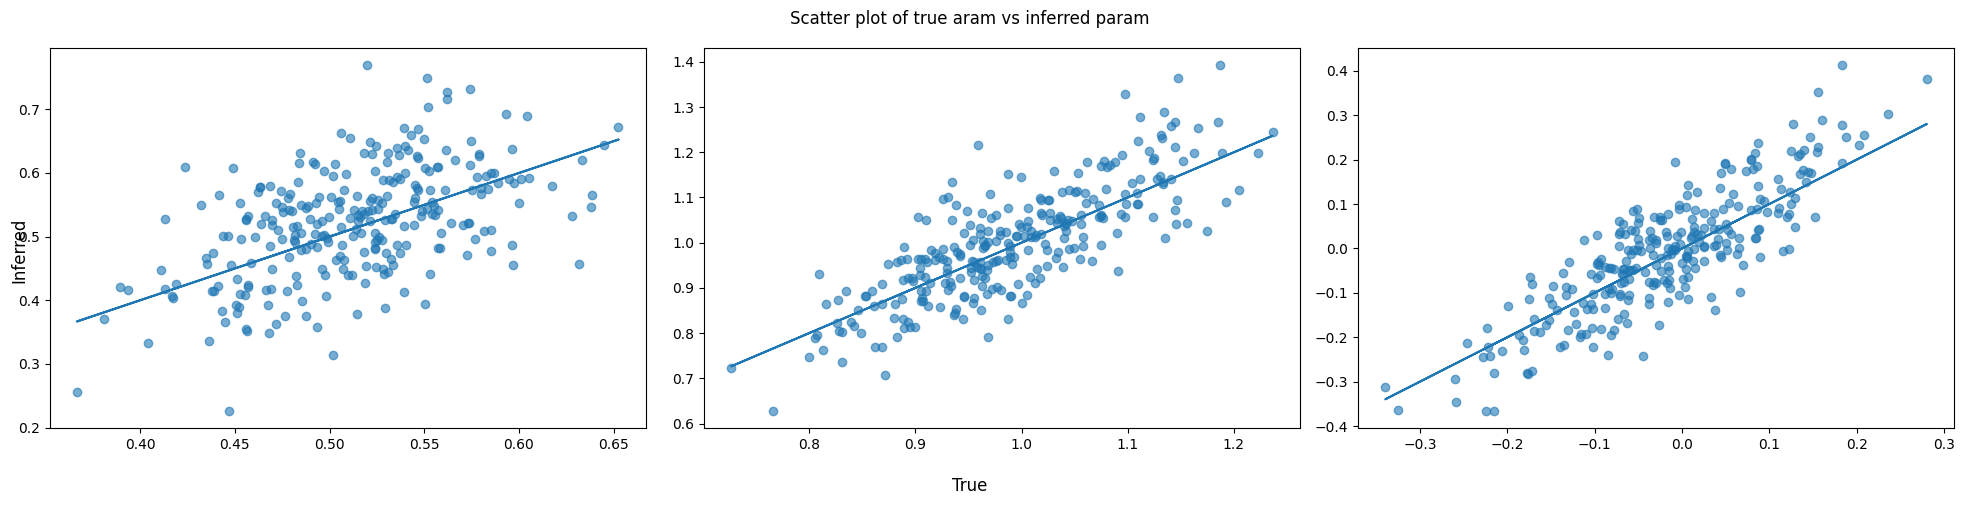

In [18]:
# Filter columns in adata.var containing 'param'
param_cols = [col for col in adata.var.keys() if 'param' in col]
param_hat = adata.var[param_cols]

fig, ax = plt.subplots(1,3,figsize=(20, 5),tight_layout=True)
for i in range(3):
  ax[i].scatter(param[:,i], param_hat.iloc[:,i], alpha=0.6)
  ax[i].plot(param[:,i],param[:,i],zorder=0)

fig.supxlabel('True')
fig.supylabel('Inferred')
fig.suptitle('Scatter plot of true aram vs inferred param')